In [276]:
# !pip install --upgrade pycaret
# !pip install cuml
# !pip install pycaret --upgrade

In [277]:
import pandas as pd
import numpy as np
from pycaret.regression import *

In [278]:
file = pd.ExcelFile("..\data\\food-twentieth-century-crop-statistics-1900-2017-xlsx.xlsx")
df = file.parse('CropStats')
df = df.set_index(df.columns[0])
df.index.name = None

## Clean Data
Columns with too many null values or meaningless information are dropped.  
Columns with unclear names are renamed.  
For the subnational column null values are filled up with corresponding values from the national column.  
For yield, production, and hectares, if one of them is null but the others in the same row are not, the null one can be calculated. Here we need to pay attention to not divide by 0.  
We chose to focus on wheat, so we will be filtering the df accordingly.  
We also added columns with logarithmic transformations for yield, production, and hectares.

In [279]:
df.drop(['admin2', 'notes', 'Harvest_year'], axis=1, inplace=True)
df.rename(columns = {'admin0': 'national', 'admin1': 'subnational', 'hectares (ha)': 'hectares_ha', 'production (tonnes)': 'production_tonnes', 'yield(tonnes/ha)': 'yield_tonnes_ha'}, inplace=True)
df.loc[df['subnational'].isna(), 'subnational'] = df['national']
# Calculate yield
mask = df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna() & ~df['hectares_ha'].isna() & df['hectares_ha'] != 0
df.loc[mask, 'yield_tonnes_ha'] = df['production_tonnes'] / df['hectares_ha']
df.dropna(subset=['yield_tonnes_ha'], inplace=True)
# Calculate production
mask = df['production_tonnes'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['hectares_ha'].isna()
df.loc[mask, 'production_tonnes'] = df['yield_tonnes_ha'] * df['hectares_ha']
df.dropna(subset=['production_tonnes'], inplace=True)
# Calculate hectares
mask = df['hectares_ha'].isna() & ~df['yield_tonnes_ha'].isna() & ~df['production_tonnes'].isna()
df.loc[mask, 'hectares_ha'] = df['yield_tonnes_ha'] * df['production_tonnes']
df.dropna(subset=['hectares_ha'], inplace=True)
# The columns we just adapted just changed into objects, let's make them floats again
df['hectares_ha'] = df['hectares_ha'].astype(float)
df['production_tonnes'] = df['production_tonnes'].astype(float)
df['yield_tonnes_ha'] = df['yield_tonnes_ha'].astype(float)
# Filter for wheat
df = df[df['crop'] == 'wheat']
# Remove the crop column
df.drop('crop', axis=1, inplace =True)
# Logarithmic transformations
df['log_yield'] = np.log1p(df['yield_tonnes_ha'])
df['log_hectares'] = np.log1p(df['production_tonnes'])
df['log_production'] = np.log1p(df['hectares_ha'])


In [280]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15479 entries, 59 to 36706
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   national           15479 non-null  object 
 1   subnational        15479 non-null  object 
 2   hectares_ha        15479 non-null  float64
 3   production_tonnes  15479 non-null  float64
 4   year               15479 non-null  int64  
 5   yield_tonnes_ha    15479 non-null  float64
 6   log_yield          15479 non-null  float64
 7   log_hectares       15479 non-null  float64
 8   log_production     15479 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.2+ MB


## Training the Model
After some testing it has been determined that using the log values gives better results.
Excluding the subnational column also gave slightly better results (I also tried omitting hectares and production as they seemed to have low importance in the feature importance tab, but that made the model less accurate).  
The df is prepped accordingly.

In [281]:
cat_features = ['national']
df.drop(['yield_tonnes_ha', 'hectares_ha', 'production_tonnes'], axis=1, inplace=True)

Eventually, we will want to do some predictions, so here we split the df. The bottom 20% we will set aside to make predictions and test the model.

In [282]:
split_index = int(len(df) * 0.2)
train_data = df.iloc[split_index:]
prediction_data_raw = df.iloc[:split_index]
prediction_data = prediction_data_raw.drop('log_yield', axis=1)

In [283]:
experiment = setup(train_data, target='log_yield', session_id=123)


,Description,Value
0,Session id,123
1,Target,log_yield
2,Target type,Regression
3,Original data shape,"(12384, 6)"
4,Transformed data shape,"(12384, 17)"
5,Transformed train set shape,"(8668, 17)"
6,Transformed test set shape,"(3716, 17)"
7,Numeric features,3
8,Categorical features,2
9,Preprocess,True


In [284]:
best_models = compare_models(n_select=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
xgboost,Extreme Gradient Boosting,0.0381,0.0028,0.0531,0.9861,0.0264,0.0417,0.0730
et,Extra Trees Regressor,0.0463,0.0045,0.0671,0.9777,0.0346,0.0542,0.3150
lightgbm,Light Gradient Boosting Machine,0.0515,0.0049,0.0696,0.9760,0.0348,0.0576,0.0920
rf,Random Forest Regressor,0.0486,0.0049,0.0695,0.9760,0.0356,0.0564,0.5760
dt,Decision Tree Regressor,0.0652,0.0091,0.0951,0.9551,0.0485,0.0743,0.0370
gbr,Gradient Boosting Regressor,0.0837,0.0120,0.1092,0.9410,0.0559,0.0990,0.2670
ridge,Ridge Regression,0.0668,0.0154,0.1116,0.9250,0.0495,0.0771,0.0340
lar,Least Angle Regression,0.0667,0.0154,0.1116,0.9249,0.0495,0.0770,0.0320
br,Bayesian Ridge,0.0667,0.0154,0.1116,0.9249,0.0495,0.0770,0.0350
lr,Linear Regression,0.0667,0.0154,0.1116,0.9249,0.0495,0.0770,0.4540


In [285]:
best_model = best_models[0]
evaluate_model(best_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [286]:
best_model = tune_model(best_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0343,0.0022,0.0464,0.9901,0.0231,0.0383
1,0.0358,0.0024,0.0486,0.9885,0.0232,0.0368
2,0.0369,0.0033,0.0571,0.9842,0.0312,0.0474
3,0.0400,0.0031,0.0554,0.9845,0.0276,0.0437
4,0.0360,0.0024,0.0495,0.9883,0.0240,0.0381
5,0.0380,0.0029,0.0536,0.9856,0.0260,0.0413
6,0.0368,0.0026,0.0505,0.9869,0.0249,0.0403
7,0.0362,0.0028,0.0532,0.9849,0.0269,0.0401
8,0.0344,0.0022,0.0471,0.9897,0.0233,0.0404


Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [287]:
predictions = predict_model(best_model, data=prediction_data)
predictions.head()

,national,subnational,year,log_hectares,log_production,prediction_label
59,Austria,Austria,1961,13.475302,12.527514,1.124901
60,Austria,Austria,1962,13.467594,12.507480,1.154856
61,Austria,Austria,1963,13.443799,12.523519,1.155836
62,Austria,Austria,1964,13.528401,12.553089,1.204276
63,Austria,Austria,1965,13.401121,12.526905,1.140484


In [290]:
save_model(best_model, 'crops_emalisa.pkl')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['year', 'log_hectares',
                                              'log_production'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categorical_imputer',
                  TransformerWrapper(excl...
                               importance_type=None,
                 

[Text(0.5, 1.0, 'Predicted vs Actual Values')]

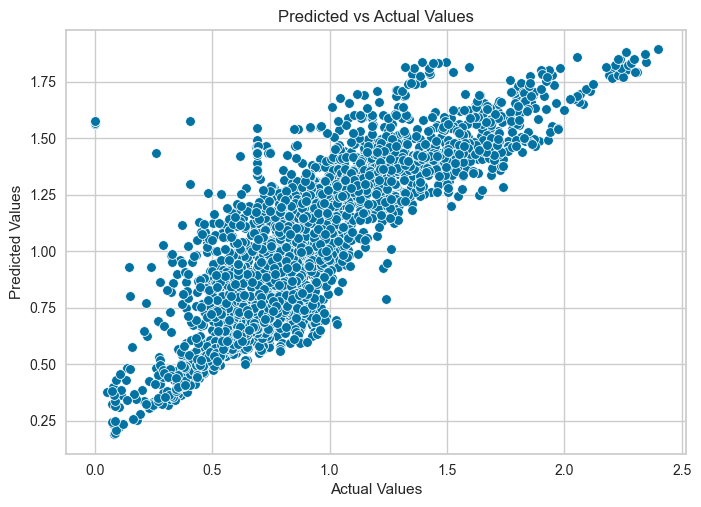

In [288]:
df_analysis = pd.DataFrame({'Actual Values': prediction_data_raw['log_yield'], 'Predicted Values': predictions['prediction_label']})
sns.scatterplot(data=df_analysis, x='Actual Values', y='Predicted Values', palette='colorblind').set(title='Predicted vs Actual Values')

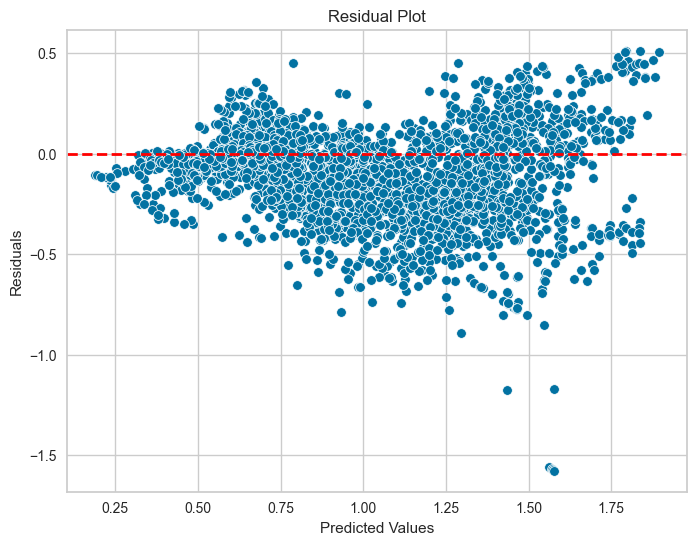

In [289]:
residuals = np.array(prediction_data_raw['log_yield']) - np.array(predictions['prediction_label'])

plt.figure(figsize=(8, 6))
sns.scatterplot(data=predictions, x='prediction_label', y=residuals, palette='colorblind')
plt.axhline(y=0, color='red', linestyle='--', linewidth=2)
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.grid(True)

# Show the plot
plt.show()